In [67]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import dataprepgpd
import modelarea
import os,datetime



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dataGPD=dataprepgpd.readGPDData('Data/Covars_yearly','Data/Targets')
dataGPD.removeZeros()

100%|██████████| 31/31 [00:00<00:00, 62.27it/s]


In [6]:
dataGPD.Xtrain.max(),dataGPD.Ytrain.shape

(14.48935957856529, (12546,))

(0.0, 30.0)

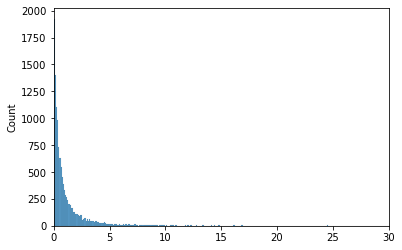

In [7]:
ax=sns.histplot(dataGPD.Ytrain)
ax.set_xlim(0,30)
# ax.set_ylim(0,250)

In [48]:
NUMBER_EPOCHS = 100
BATCH_SIZE=4
filepath="AD_ckpt_GPD"
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
    options=None
)
def train(model, xdata,ydata):
    hist = model.fit(x=xdata,
                     y=ydata,
                     epochs=NUMBER_EPOCHS,
                     validation_split=0.2, 
                     batch_size=BATCH_SIZE,#auto validate using 30% of random samples at each epoch
                     verbose=1, callbacks=[model_checkpoint_callback]
                    )
    return hist

In [10]:
from scipy.stats import genpareto
pareto=genpareto.fit(dataGPD.Ytrain)
shape,loation,scale=float(pareto[0]),float(pareto[1]),float(pareto[2])


In [12]:
dataGPD.Xtrain.max()

14.48935957856529

[(0.0, 5.0)]

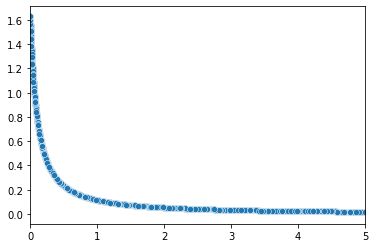

In [13]:
sns.scatterplot(x=dataGPD.Ytrain,y=genpareto.pdf(dataGPD.Ytrain,5,pareto[1],pareto[2])).set(xlim=(0,5))

<AxesSubplot:ylabel='Count'>

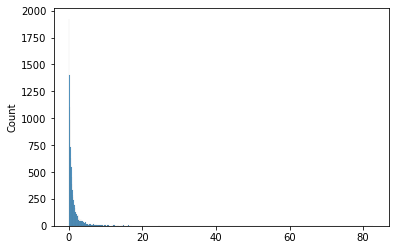

In [14]:
sns.histplot(dataGPD.Ytrain)

In [68]:
modelArea=modelarea.ADModel(loation,scale,shape)
modelArea.getAreaDensityModel()
modelArea.getOptimizer()
modelArea.compileModel()
modelArea.model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 17)]              0         
                                                                 
 AR_DN_0 (Dense)             (None, 64)                1152      
                                                                 
 AR_DN_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_602 (Ba  (None, 64)               256       
 tchNormalization)                                               
                                                                 
 dropout_602 (Dropout)       (None, 64)                0         
                                                                 
 activation_602 (Activation)  (None, 64)               0         
                                                          

In [55]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
scaler.fit(dataGPD.Xtrain)
arr=scaler.transform(dataGPD.Xtrain)
arr=MinMaxScaler(feature_range=(0,1)).fit(arr).transform(arr)
print(f"{arr.min()}")

0.0


In [69]:
hist=train(modelArea.model,arr,np.expand_dims(dataGPD.Ytrain,axis=1))

Epoch 1/100
2509/2509 [==============================] - 130s 48ms/step - loss: 35.5459 - mae: 1.2769 - val_loss: 30.4100 - val_mae: 0.9408
Epoch 2/100
2509/2509 [==============================] - 123s 49ms/step - loss: 34.1108 - mae: 1.2873 - val_loss: 30.2448 - val_mae: 0.9379
Epoch 3/100
2509/2509 [==============================] - 122s 49ms/step - loss: 34.0810 - mae: 1.2871 - val_loss: 30.2023 - val_mae: 0.9375
Epoch 4/100
2509/2509 [==============================] - 121s 48ms/step - loss: 34.0726 - mae: 1.2876 - val_loss: 30.3288 - val_mae: 0.9394
Epoch 5/100
2509/2509 [==============================] - 143s 57ms/step - loss: 34.0629 - mae: 1.2868 - val_loss: 30.1249 - val_mae: 0.9374
Epoch 6/100
2509/2509 [==============================] - 124s 49ms/step - loss: 34.0602 - mae: 1.2870 - val_loss: 30.1286 - val_mae: 0.9379
Epoch 7/100
2509/2509 [==============================] - 124s 49ms/step - loss: 34.0667 - mae: 1.2873 - val_loss: 30.2515 - val_mae: 0.9380
Epoch 8/100
2509/250

In [61]:
out=modelArea.model.predict(arr)

In [63]:
out[:,0]

array([0.9999976 , 0.9999993 , 0.9999993 , ..., 0.9999993 , 0.99999917,
       0.9999993 ], dtype=float32)

In [ ]:
sns.scatterplot(x=np.log(dataGPD.Ytrain)+20,y=out.flatten())

In [ ]:
ax=sns.histplot(data=dataGPD.Ytrain.flatten())#histplot(modelArea.model.predict(dataGPD.Xtrain))
# ax.set(xlim=(0.1,4),ylim=(0,100))

In [ ]:
import tensorflow_probability as tfp
dist=tfp.distributions.GeneralizedPareto(loc=1, scale=scale, concentration=1.985857028856136)

In [ ]:
ax=sns.scatterplot(x=np.arange(1,20,0.1),y=dist.prob(np.arange(1,20,0.1)).numpy())
ax.set(xlim=(0.001,30),ylim=(0,1.5))

In [ ]:
dist.prob(np.arange(1,20,0.1)).numpy().min()